#  ARIMA
* 自回归移动平均模型（ ARIMA）是最常用的时间序列预测模型。
* 时间序列模型通常适用于做短期预测，即统计序列过去的变化模式还未发生根本性变化
* 对于平稳非白噪声序列，它的均值和方差是常数。通常是建立一个线性模型来拟合该序列的发展，借此提取该序列的有用信息。ARMA模型是最常用的平稳序列拟合模型。 

## 1.预处理
1. 平稳
就是围绕着一个常数上下波动且波动范围有限，即有常数均值和常数方差。如果有明显的趋势或周期性，那它通常不是平稳序列。
2. 纯随机性检验
对于纯随机序列，又称白噪声序列，序列的各项数值之间没有任何相关关系，序列在进行完全无序的随机波动，可以终止对该序列的分析。白噪声序列是没有信息可提取的平稳序列。

In [1]:
import sklearn
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVR
import h5py
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
from matplotlib import pyplot as plt

In [18]:
fname = 'BJ{}_M32x32_T30_InOut.h5'.format(14)
reader=h5py.File(fname,'r')
data=reader['data'].value
date=reader['date'].value

In [19]:
print(len(data))

4780


In [20]:
data[0,1]

array([[  1.,  30.,  66., ...,   8.,   3.,  93.],
       [  0.,  24.,  25., ...,  47.,  21., 190.],
       [  0.,  14.,  17., ...,  24., 546., 349.],
       ...,
       [  3.,   5.,  22., ...,  18.,  13.,   7.],
       [  0.,   6.,  10., ...,  14.,   0.,   9.],
       [  0.,   7.,   2., ...,  26.,  30.,  14.]])

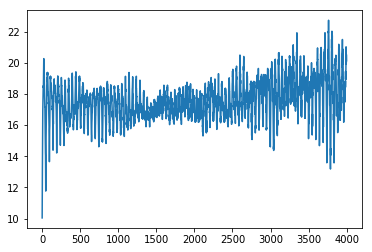

In [22]:
%matplotlib inline
v=[]
varr=[]
for i in range(1,4000):
    t=[]
    for j in range(4700-i):
        a=data[j,0,15,15]
        b=data[j+i,0,15,15]
        t.append(a-b)
    v.append(sum(t)/len(t))
    varr.append(np.var(t))
plt.plot(varr)

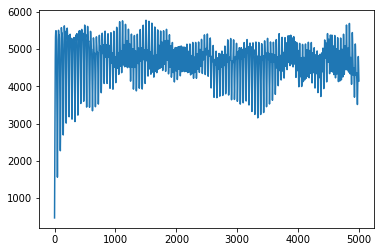

In [7]:
plt.plot(varr)

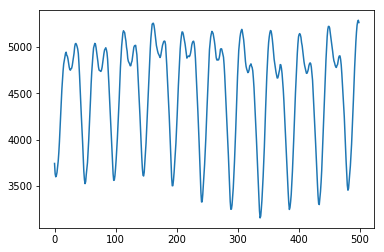

In [11]:
plt.plot(varr[3000:3500])

In [65]:
train_data_all=[]
for timeslot in data:
    train_data_all.append(timeslot[0][15][10])


In [5]:
train_data=train_data_all[0:48]

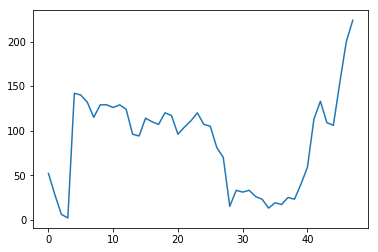

In [6]:
plt.plot(train_data)

In [7]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [8]:
from statsmodels.tsa.stattools import adfuller
print('原始序列的检验结果为：',adfuller(train_data))

原始序列的检验结果为： (-1.8261619719814788, 0.36755251682618983, 7, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, 327.3253360324116)


adfuller()返回值依次为：adf, pvalue p值， usedlag, nobs, critical values临界值 , icbest, regresults, resstore
这里p值远小于0.05 可以看成平稳序列

In [9]:
diff1=np.diff(train_data)

In [10]:
print(len(diff1))

47


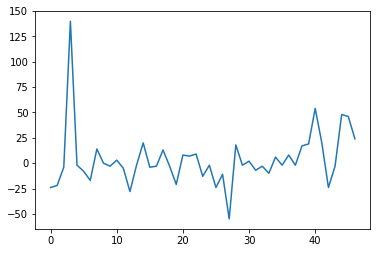

In [11]:
plt.plot(diff1)

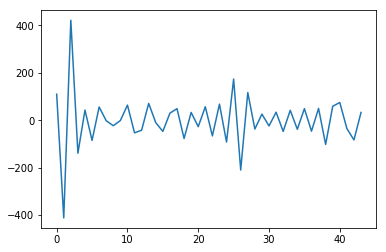

In [20]:
diff3=np.diff(diff2)
plt.plot(diff3)

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(train_data, lags= 1)) #返回统计量和 p 值

差分序列的白噪声检验结果： (array([31.02398266]), array([2.5485976e-08]))


对一阶差分后的序列做白噪声检验

In [13]:
from statsmodels.tsa.arima_model import ARIMA 

pmax = int(len(diff1) / 1000)    #一般阶数不超过 length /10
qmax = int(len(diff1) / 1000)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(diff1, (p, 1, q)).fit().bic)
        except:
            temp.append(None)
        bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_matrix.stack().idxmin() #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1

BIC 最小的p值 和 q 值：0,0


In [14]:
model = ARIMA(train_data[0:48], (p,1,q)).fit()
model.summary2()        #生成一份模型报告
model.forecast(5)   #为未来5天进行预测， 返回预测结果， 标准误差， 和置信区间

(array([227.65957447, 231.31914894, 234.9787234 , 238.63829787,
        242.29787234]),
 array([27.94696847, 39.52298184, 48.40556931, 55.89393694, 62.49132126]),
 array([[172.88452279, 282.43462615],
        [153.85552797, 308.7827699 ],
        [140.10555091, 329.8518959 ],
        [129.08819452, 348.18840123],
        [119.81713332, 364.77861136]]))

In [15]:
train_data_all[49:55]

[249.0, 253.0, 230.0, 216.0, 206.0, 208.0]

In [16]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARIMA
==================================================================
Model:              ARIMA            BIC:                 454.1295
Dependent Variable: D.y              Log-Likelihood:      -223.21 
Date:               2018-10-14 16:37 Scale:               1.0000  
No. Observations:   47               Method:              css     
Df Model:           1                Sample:              1       
Df Residuals:       46                                    8       
Converged:          1.0000           S.D. of innovations: 27.947  
No. Iterations:     0.0000           HQIC:                451.822 
AIC:                450.4292                                      
---------------------------------------------------------------------
         Coef.     Std.Err.      t       P>|t|      [0.025     0.975]
---------------------------------------------------------------------
const    3.6596      4.0765    0.8977    0.3740    -4.3302    11.6493
==================================================================

"""